# Predicting Ethiopian Vehicle Insurance Premiums

- The goal of this project is to clean, analyse and predict vehicle insurance premiums of the state-owned Ethiopian Insurance Corporation.
- The dataset we'll use describes vehicles, their insurance premiums and other insurance related atributes from July 2011 to June 2018. It can be found on [Mendeley Data](https://data.mendeley.com/datasets/34nfrk36dt/1).

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans


import xgboost as xgb
from scipy.stats import expon, kstest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fuzzywuzzy import process

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Dataset

In [2]:
insurance_data_1 = pd.read_csv("insuranceData/motor_data11-14lats.csv")
insurance_data_2 = pd.read_csv("insuranceData/motor_data14-2018.csv")

## Predefined function 

In [3]:
def plot_counts_and_premiums(ax, count_series, premium_series, xlabel):
    index = count_series.index
    x = np.arange(len(index))
    w = 0.4

    ax.bar(x - w/2, count_series.values, w, label="Policy Count", color="tab:red")
    ax.set_ylabel("Policy Count", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_xlabel(xlabel)
    ax.set_xticks(x)
    ax.set_xticklabels(index)

    ax2 = ax.twinx()
    ax2.bar(x + w/2, premium_series.loc[index].values, w, label="Premium Sum", color="tab:blue")
    ax2.set_ylabel("Premium Sum", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

## Dataset overview

Both of the provided dataset files include the same entry attributes and differ only in entry dates. They will need to be merged.

In [4]:
insurance_data = pd.concat([insurance_data_1, insurance_data_2], ignore_index=True)

print(insurance_data.shape)

(802036, 16)


We have 802036 insurance policy records and 16 policy related attributes.

Now let's look whether the provided attributes have been read correctly.

In [5]:
insurance_data.head(10)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43
5,0,08-AUG-12,07-AUG-13,08,1202,285451.24,4286.650,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,26916.44
6,0,08-AUG-11,07-AUG-12,08,1202,285451.24,4123.564,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
7,0,08-JUL-11,07-AUG-11,08,1202,285451.24,155.010,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,NaN
8,0,08-JUL-12,07-JUL-13,11,1201,200000.00,3452.650,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN
9,0,08-AUG-11,07-JUL-12,11,1201,200000.00,3077.540,5000030346,1982.0,10.0,NaN,Station Wagones,4164.0,TOYOTA,Private,NaN


There are multiple entries regarding the same vehicle as it has to be reinsured at least every year.

In [6]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

Columns seem to have been read correctly. Let's now look at the column values in individually.

### Object ID

In [7]:
insurance_data["OBJECT_ID"].value_counts()

OBJECT_ID
5000607848    17
5000116673    17
5000036245    16
5000036477    16
5000021028    16
              ..
5001337147     1
5001337146     1
5001328698     1
5001336495     1
5001330508     1
Name: count, Length: 288763, dtype: int64

Some vehicles appear more that 7 times in the dataset. This can happen when a vehicle is reinsured multiple times in a given year. The opposite is also possible: a vehicle can appear only once in the dataset if was insured with company A and then with company B or not insured at all at a later date.

In [8]:
insurance_data[insurance_data["OBJECT_ID"].astype(str) == "5000116673"]

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
75918,1,31-JUL-13,30-JUL-14,11,1202,414000.0,6564.04,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75919,0,08-JUL-13,07-JUL-14,88,1202,120000.0,2643.35,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75920,0,04-NOV-12,07-JUL-13,88,1202,241442.0,3802.86,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75921,0,08-SEP-12,03-NOV-12,88,1202,241442.0,1191.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75922,1,31-JUL-12,30-JUL-13,11,1202,414000.0,4473.66,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75923,0,08-JUL-12,07-SEP-12,88,1202,241442.0,1966.70,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75924,1,31-JUL-11,30-JUL-12,11,1202,414000.0,3718.13,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75925,0,08-OCT-11,07-JUL-12,88,1202,241442.0,4136.43,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
75926,0,08-JUL-11,07-OCT-11,11,1202,241442.0,1028.48,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN
359619,1,31-MAR-18,30-MAR-19,13,1202,600000.0,5576.76,5000116673,2006.0,0.0,220.0,Trailers and semitrailers,0.0,MESFIN,General Cartage,NaN


In [9]:
(insurance_data["OBJECT_ID"].value_counts() > 7).sum()

np.int64(7290)

There are a total of 7290 object IDs that apprear more than 7 times.

It quickly becomes clear that we are dealing with a dataset with many errors. For the same object ID, there are entries that are not clearly logically intertwined. For example, in the table above, the first entry shows that `EFFECTIVE_YR` is 11 and in the entry below, that `EFFECTIVE_YR` is 88. However, we can still perform predictive analysis under the presumption that each row in the dataset represents a unique vehicle.

### Sex

In [10]:
insurance_data["SEX"].value_counts()

SEX
0    415297
1    318650
2     68089
Name: count, dtype: int64

In the dataset, there are 3 unique sex values with 0 being legal entities, 1 - males and 2 - females. The number of insurance contracts where men are the policyholders is 4.67 times greater that the number of contracts with female policyholders. That is due to women being less likely to have a drivers license in Ethiopia.

Let's remap the values for better clarity.

In [11]:
sex_mapping = {0:"LEGAL ENTITY", 1:"MALE", 2:"FEMALE"}

insurance_data["SEX"] = insurance_data["SEX"].map(sex_mapping)

insurance_data["SEX"].value_counts()

SEX
LEGAL ENTITY    415297
MALE            318650
FEMALE           68089
Name: count, dtype: int64

Let's also look at the log premium distribution with regard to sex.

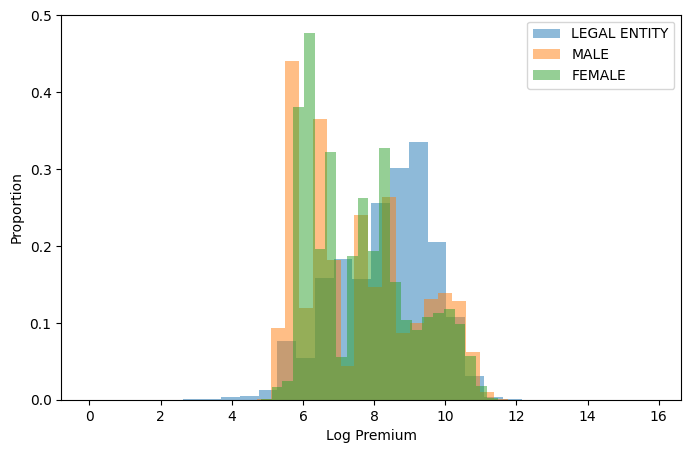

In [12]:
insurance_data["LOG_PREMIUM"] = np.log(insurance_data["PREMIUM"] + 1)

sex_values = insurance_data["SEX"].unique()

plt.figure(figsize=(8, 5))

for sex in sex_values:
    subset = insurance_data[insurance_data["SEX"] == sex]["LOG_PREMIUM"]
    plt.hist(subset, bins=30, alpha=0.5, label=str(sex), density=True)

plt.xlabel("Log Premium")
plt.ylabel("Proportion")
plt.legend()
plt.show()

The distributions of premiums for males and females are practically inseparable. For legal entities, however, the premiums seem to be larger.

### Insurance start & end date

In [13]:
insurance_data["INSR_BEGIN"].value_counts()

INSR_BEGIN
08-JUL-17    16754
08-JUL-16    15640
08-JUL-11    15215
08-JUL-15    13464
08-JUL-14    13121
             ...  
29-MAY-13        3
28-SEP-15        3
03-MAR-15        1
12-SEP-14        1
12-SEP-12        1
Name: count, Length: 2556, dtype: int64

In [14]:
insurance_data["INSR_END"].value_counts()

INSR_END
07-JUL-18    17378
07-JUL-17    15827
07-JUL-16    14864
07-JUL-13    13594
07-JUL-15    13248
             ...  
19-OCT-11        1
03-DEC-11        1
01-MAY-12        1
04-SEP-11        1
21-AUG-11        1
Name: count, Length: 2834, dtype: int64

There do not seem to be any obvious errors in the data. Yet, we must check whether there are entries where the insurance start date is later than the end date.

In [15]:
insurance_data["INSR_BEGIN"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y")

insurance_data["INSR_END"] = pd.to_datetime(insurance_data["INSR_END"], format="%d-%b-%y")

end_greater_start = insurance_data["INSR_BEGIN"] > insurance_data["INSR_END"]
length = len(end_greater_start[end_greater_start == True])
length

0

No end values are earlier than start values. We can now visualize the variable data.

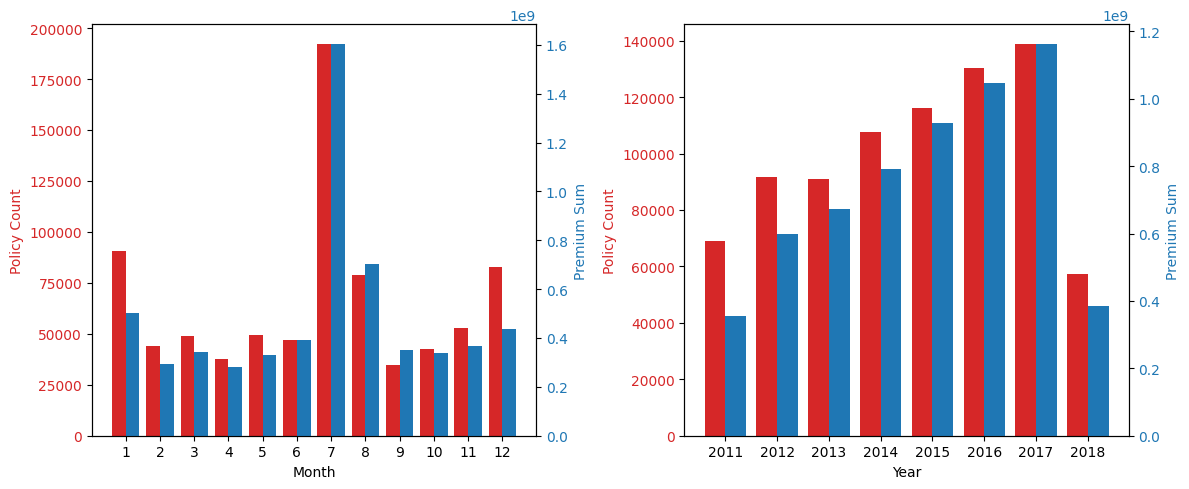

In [16]:
insurance_data["INSR_START_MONTH"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.month
insurance_data["INSR_START_YEAR"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.year

start_months = insurance_data["INSR_START_MONTH"].value_counts().sort_index()
start_months_premium = insurance_data.groupby("INSR_START_MONTH")["PREMIUM"].sum()

start_years = insurance_data["INSR_START_YEAR"].value_counts().sort_index()
start_years_premium = insurance_data.groupby("INSR_START_YEAR")["PREMIUM"].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_counts_and_premiums(axes[0], start_months, start_months_premium, "Month")
plot_counts_and_premiums(axes[1], start_years, start_years_premium, "Year")

fig.tight_layout()
plt.show()

From the charts it becomes clear that policy count closely correlates with premium sums with regard to both the month and the year of the insurance start date. One month in particular, July, stands out as the month in which the most policies are introduced. Also, January and December seem to be months where more policies are introduced than usual. This could be due to accounting methods in which a policy signed near the end of the fiscal year is counted as being signed in the next year. In terms of the trend regarding the year, there is a clear pattern of growth from 2011 to 2017 and a sharp drop off of new policies in 2018. The drop off can be explained by the end of data collection period being June of 2018. We can check whether growth in the month of June in the respective years is equally as rapid.

In [17]:
before_june = insurance_data[(insurance_data["INSR_START_YEAR"].isin([2017, 2018])) & (insurance_data["INSR_START_MONTH"] < 7)]

before_june.groupby("INSR_START_YEAR").size().reset_index(name="Policy Count")

,INSR_START_YEAR,Policy Count
0,2017,55693
1,2018,57300


The pace of growth is about the same.

Let's also create a dummy variable for insurance start days.

In [18]:
insurance_data["INSR_START_DAY"] = pd.to_datetime(insurance_data["INSR_BEGIN"], format="%d-%b-%y").dt.day

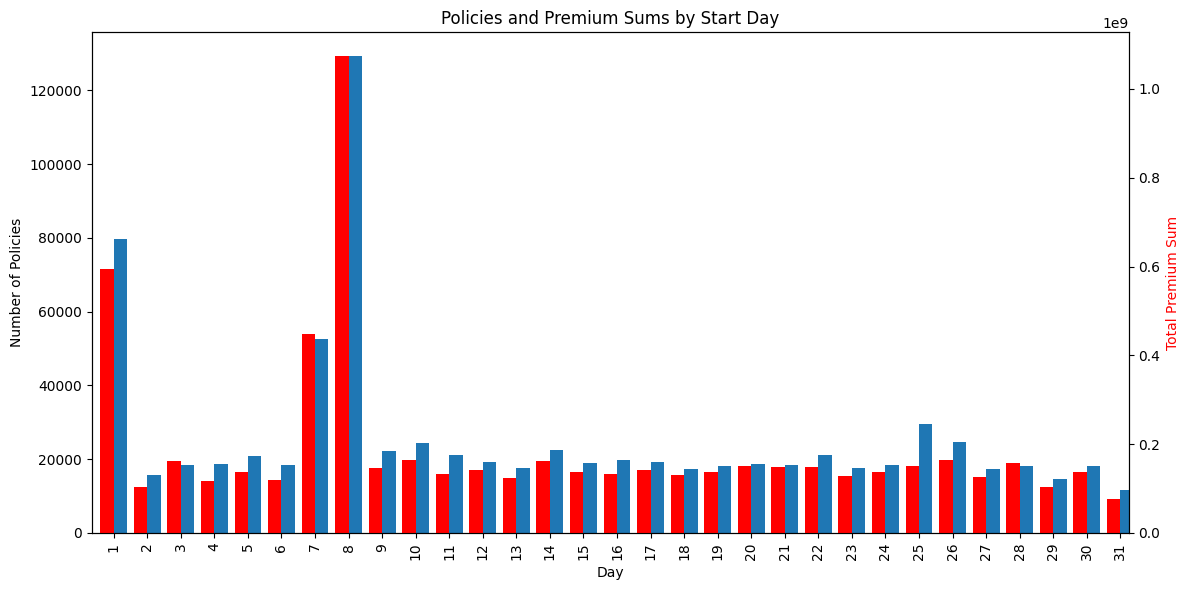

In [19]:
day_stats = insurance_data.groupby("INSR_START_DAY").agg(
    policy_count=("PREMIUM", "count"),
    premium_sum=("PREMIUM", "sum")
)

fig, ax1 = plt.subplots(figsize=(12, 6))

day_stats["policy_count"].plot(kind="bar", ax=ax1, position=0, width=0.4, label="Policy Count")

ax2 = ax1.twinx()
day_stats["premium_sum"].plot(kind="bar", color="red", ax=ax2, position=1, width=0.4, label="Premium Sum")

ax1.set_xlabel("Day")   
ax1.set_ylabel("Number of Policies")
ax2.set_ylabel("Total Premium Sum", color="red")
plt.title("Policies and Premium Sums by Start Day")
plt.tight_layout()

plt.show()

The largest number of policies were registered on the 1st, the 7th and the 8th. This is abnormal, and the distribution should be uniform. This issue should be escalated to the data owners.

### Effective year

In [20]:
insurance_data["EFFECTIVE_YR"].value_counts()

EFFECTIVE_YR
11    199888
12     86791
15     75484
14     74001
16     68866
       ...  
8R         1
RS         1
IN         1
/1         1
EA         1
Name: count, Length: 151, dtype: int64

The effective year variable indicates what year the policy came into effect (was first insured with the company). There are numerous records that indicate a year before the historic start date of the dataset - 2011.

Yet, the column contains values that are not indicative of a number and should be removed. Since there are a total of 802036 records, we can afford to lose quite a few. We also need to convert the years into a four-digit number as a two-digit year encoding is only common on legacy data storage systems.

In [21]:
insurance_data = insurance_data[insurance_data["EFFECTIVE_YR"].astype(str).str.match(r"^\d{2}$")]

def convert_year(y):
    y = int(y)
    if y > 18:
        return 1900 + y
    else:
        return 2000 + y

insurance_data["EFFECTIVE_YR_FULL"] = insurance_data["EFFECTIVE_YR"].apply(convert_year)

insurance_data.shape

(800865, 21)

After cleaning the effective year column, we have lost 1171 rows.

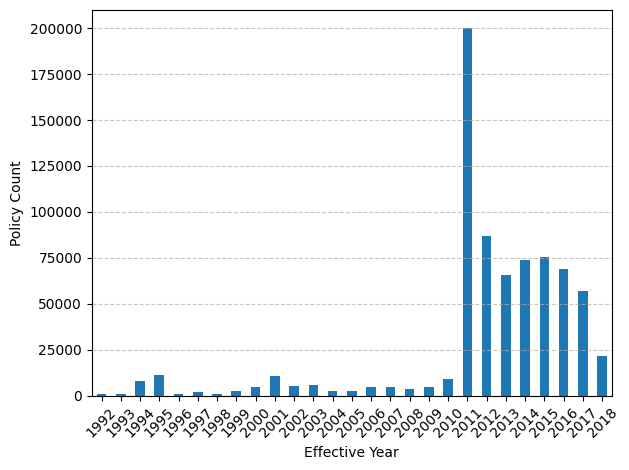

In [22]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()

year_counts = year_counts[
    (year_counts.index >= 1992) &
    (year_counts.index <= 2018)
]

year_counts.plot(kind="bar")
plt.xlabel("Effective Year")
plt.ylabel("Policy Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
year_counts = insurance_data["EFFECTIVE_YR_FULL"].value_counts().sort_index()
print(year_counts)

EFFECTIVE_YR_FULL
1919      394
1920      593
1921      532
1922      454
1923      488
        ...  
2014    74001
2015    75484
2016    68866
2017    57060
2018    21547
Name: count, Length: 100, dtype: int64


The data shows that most of the insured vehicles were first insured in 2011 and later. After contacting the postdoctoral fellow that published the dataset, I was informed that the meaning of this variable is not very well documented. There are values of 1947 and prior, eventhough, in Ethiopia, the first motor insurance was issued in 1947. This variable will be dropped.

In [24]:
insurance_data.drop(columns=["EFFECTIVE_YR", "EFFECTIVE_YR_FULL"], inplace=True)

### Insurance type

In [25]:
insurance_data["INSR_TYPE"].value_counts()

INSR_TYPE
1202    593519
1201    207011
1204       335
Name: count, dtype: int64

There are a total of three types of insurance: 1201 - private, 1202 - commercial and 1204 - motor trade road risk (for motor trade workers that drive vehicles they do not personally own, such as mechanics when testing repaired vehicles).

Let's change the values so they make more sense.

In [26]:
insurance_type_mapping = {1202:"PRIVATE", 1201:"COMMERCIAL", 1204:"MOTOR TRADE"}

insurance_data["INSR_TYPE"] = insurance_data["INSR_TYPE"].map(insurance_type_mapping)

In [27]:
insurance_data["INSR_TYPE"].value_counts()

INSR_TYPE
PRIVATE        593519
COMMERCIAL     207011
MOTOR TRADE       335
Name: count, dtype: int64

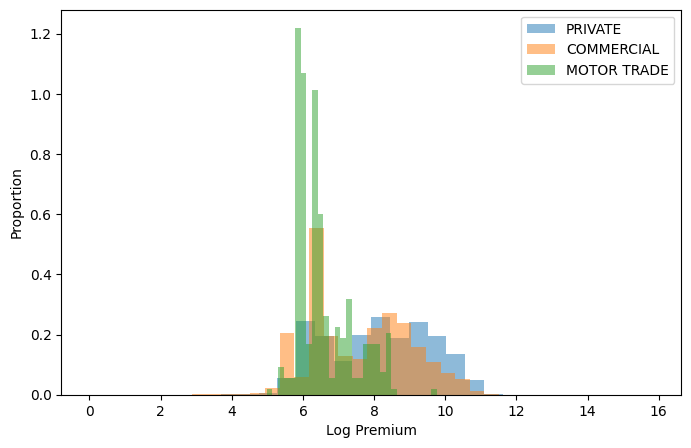

In [28]:
insurance_type_values = insurance_data["INSR_TYPE"].unique()

plt.figure(figsize=(8, 5))

for type in insurance_type_values:
    subset = insurance_data[insurance_data["INSR_TYPE"] == type]["LOG_PREMIUM"]
    plt.hist(subset, bins=30, alpha=0.5, label=str(type), density=True)

plt.xlabel("Log Premium")
plt.ylabel("Proportion")
plt.legend()
plt.show()

Here, motor trade insurance premiums are not as high as private and commercial premiums. Commercial and private insurance premiums are distributed around the same. It should also be noted that the log premium value range is similar for latter mentioned groups.


### Insured value

In [29]:
insurance_data["INSURED_VALUE"].value_counts()

INSURED_VALUE
0.00          343235
500000.00      13588
400000.00      12553
1500000.00     10844
600000.00      10658
               ...  
844621.79          1
1611552.52         1
59099.99           1
795738.00          1
2539089.00         1
Name: count, Length: 17368, dtype: int64

343235 vehicles in the dataset have no provided insurance value. An insured value of 0 means the policyholder has the liability insurance coverage only, not the comprehensive coverage while an insured value higher than 0 indicates comprehensive coverage.

The difference between liability and comprehensive insurance is that liability insurance covers damage or injury you cause to other people or their property (and not repairs to your vehicle) and comprehensive insurance covers non-collision damage to your own car.

For the purpose of developing a model, we may create an additional variable that indicates the type of insurance the policyholder has.

In [30]:
insurance_data["INSR_COVER"] = np.where(
    insurance_data["INSURED_VALUE"] == 0,
    "LIABILITY",
    "COMPREHENSIVE"
)

insurance_data["INSR_COVER"].value_counts()

INSR_COVER
COMPREHENSIVE    457630
LIABILITY        343235
Name: count, dtype: int64

In [31]:
insurance_data["INSURED_VALUE"].describe()

count    8.008650e+05
mean     5.089766e+05
std      9.020327e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.800000e+05
75%      7.300000e+05
max      2.500000e+08
Name: INSURED_VALUE, dtype: float64

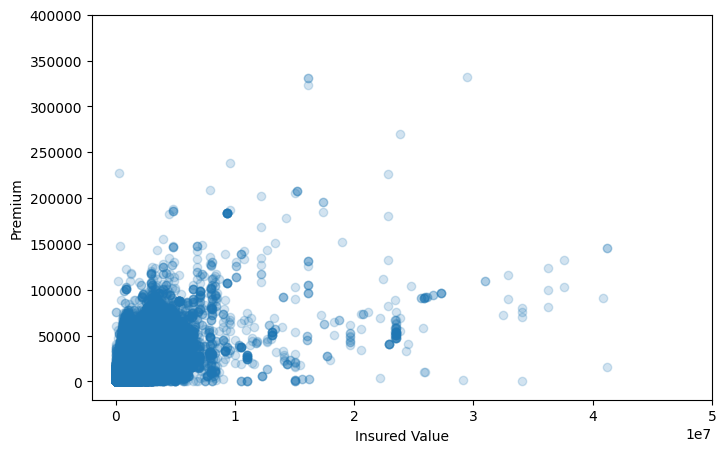

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(insurance_data["INSURED_VALUE"], insurance_data["PREMIUM"], alpha=0.2)
plt.xlabel("Insured Value")
plt.ylabel("Premium")
plt.xlim([-2000000, 50000000])
plt.ylim([-20000, 400000])
plt.show()

It is unlikely that there is a strong linear relation between insured value and premiums.

<Axes: ylabel='Frequency'>

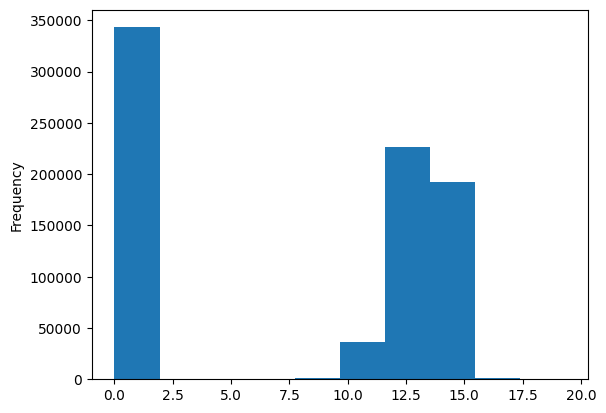

In [33]:
insurance_data["LOG_INSURED_VALUE"] = np.log(insurance_data["INSURED_VALUE"] + 1)

insurance_data["LOG_INSURED_VALUE"].plot(kind="hist")

Since there are 2 pronounced groups with different values ranges, variable bucketing is the better option.

In [34]:
insurance_data["INSURED_VALUE_GROUP"] = pd.qcut(
    insurance_data.loc[insurance_data["INSURED_VALUE"] > 0, "INSURED_VALUE"], 
    q=3,
    labels=["LOW", "MEDIUM", "HIGH"]
)

insurance_data["INSURED_VALUE_GROUP"] = insurance_data["INSURED_VALUE_GROUP"].cat.add_categories("ZERO")
insurance_data.loc[insurance_data["INSURED_VALUE"] == 0, "INSURED_VALUE_GROUP"] = "ZERO"

### Year of production

In [35]:
insurance_data["PROD_YEAR"].value_counts()

PROD_YEAR
2012.0    61161
2014.0    52385
2010.0    47290
2015.0    46865
2013.0    45130
          ...  
1953.0       12
1955.0        5
1954.0        5
1951.0        5
1952.0        3
Name: count, Length: 69, dtype: int64

In [36]:
insurance_data["PROD_YEAR"].unique()

array([2007., 2010., 1982., 2012., 1998., 1990., 2004., 2005., 2008.,
       1999., 1995., 2000., 1985., 1991., 1993., 1974., 1997., 2002.,
       2003., 2006., 1983., 1988., 1984., 2009., 2013., 1980., 1992.,
       1981., 1986., 1976., 1994., 1987., 1969., 1979., 1989., 2001.,
       1973., 1975., 1996., 2011., 1977., 2014., 1971., 1972., 2017.,
       2016., 1970., 1978., 1967., 1963., 2018., 1964., 1961., 1957.,
       1965., 1966., 1968., 2015., 1953., 1960., 1958., 1962.,   nan,
       1959., 1950., 1955., 1954., 1952., 1956., 1951.])

We have NaN values in our dataset. Instead of removing them, we can fill them with median values and preserve the central tendency.

In [37]:
insurance_data[insurance_data["PROD_YEAR"] == np.nan].shape[1]

22

In [38]:
insurance_data["PROD_YEAR"] = insurance_data["PROD_YEAR"].fillna(insurance_data["PROD_YEAR"].median())

In [39]:
insurance_data["PROD_YEAR"].describe()

count    800865.000000
mean       2004.538395
std          10.224167
min        1950.000000
25%        2000.000000
50%        2008.000000
75%        2012.000000
max        2018.000000
Name: PROD_YEAR, dtype: float64

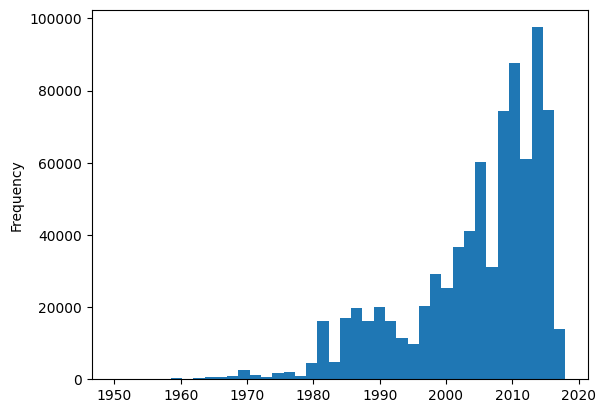

In [40]:
insurance_data["PROD_YEAR"].plot(kind="hist", bins=40)
plt.show()

The production year variable is heavily left-skewed, but are no abnormalities in this attribute. We can create an additional variable for vehicle age.

In [41]:
max_insr_date = pd.to_datetime(insurance_data["INSR_BEGIN"].max())

prod_year_dt = pd.to_datetime(insurance_data["PROD_YEAR"], format="%Y")

insurance_data["VEHICLE_AGE"] = (max_insr_date - prod_year_dt).dt.days / 365

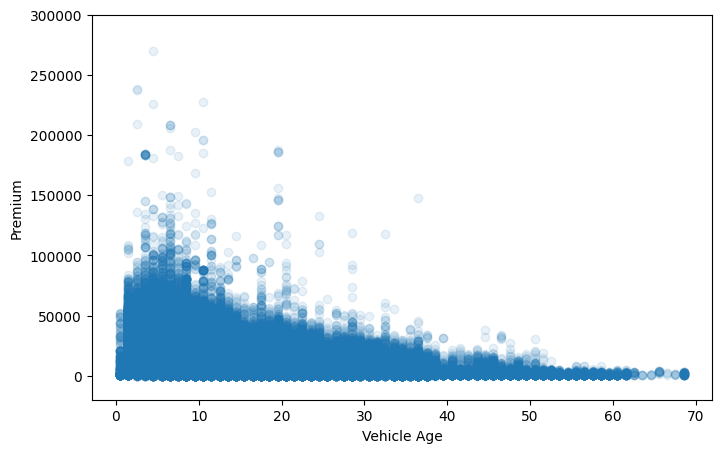

In [42]:
plt.figure(figsize=(8, 5))
plt.scatter(insurance_data["VEHICLE_AGE"], insurance_data["PREMIUM"], alpha=0.1)
plt.xlabel("Vehicle Age")
plt.ylabel("Premium")
plt.ylim([-20000, 300000])
plt.show()

Premiums tend to stabilize and decrease as vehicles age. There are likely few antique vehicles in Ethiopia, so practically all vehicles become less valuable with age.

### Number of seats

In [43]:
insurance_data["SEATS_NUM"].describe()

count    800630.000000
mean          6.132910
std          13.410633
min           0.000000
25%           1.000000
50%           4.000000
75%           4.000000
max         199.000000
Name: SEATS_NUM, dtype: float64

In [44]:
insurance_data["SEATS_NUM"].value_counts()

SEATS_NUM
4.0      232920
1.0      151849
2.0       98922
3.0       82660
0.0       59704
          ...  
125.0         1
199.0         1
112.0         1
72.0          1
71.0          1
Name: count, Length: 96, dtype: int64

There are a total of 59703 vehicles with 0 seats which is impossible. Also, the number of seats should not exceed 256 (seats in the largest bus in the world). Other values will be considered correct.

In [45]:
insurance_data = insurance_data[(insurance_data["SEATS_NUM"] > 0) & (insurance_data["SEATS_NUM"] <= 256)]

print(insurance_data.shape)

(740926, 23)


### Carrying capacity

In [46]:
insurance_data["CARRYING_CAPACITY"].value_counts()

CARRYING_CAPACITY
0.0        217112
7.0         62161
10.0        36928
3.0         23943
6.0         23412
            ...  
17515.0         1
2446.0          1
13900.0         1
463.0           1
117.3           1
Name: count, Length: 2191, dtype: int64

It is clear that the seat number variable and the carrying capacity variable are not clearly differentiated. They have been mixed up and should be removed.

In [47]:
insurance_data.drop(columns=["SEATS_NUM", "CARRYING_CAPACITY"], inplace=True)

### Vehicle type

In [48]:
insurance_data["TYPE_VEHICLE"].value_counts()

TYPE_VEHICLE
Truck                        145772
Pick-up                      143059
Motor-cycle                  139703
Automobile                   124388
Bus                          105615
Station Wagones               59828
Tanker                        10078
Special construction           7744
Tractor                        4094
Trailers and semitrailers       645
Name: count, dtype: int64

Nothing out of the ordinary here. We will capitalize the letters for consistency.

In [49]:
insurance_data["TYPE_VEHICLE"] = insurance_data["TYPE_VEHICLE"].str.upper()

### Vehicle weight

In [50]:
insurance_data["CCM_TON"].describe()

count    740926.000000
mean       3339.153060
std        3416.444074
min           0.000000
25%         998.000000
50%        2494.000000
75%        4164.000000
max       20000.000000
Name: CCM_TON, dtype: float64

In [51]:
insurance_data["CCM_TON"].value_counts()

CCM_TON
4164.0    60703
2494.0    41761
0.0       41009
200.0     30770
4334.0    25802
          ...  
2586.0        1
4424.0        1
3979.0        1
2541.0        1
1093.0        1
Name: count, Length: 3659, dtype: int64

This variable is related to the weight of the vehicle. Since it is not clearly described how and what units are being used when (cubic centimers or tones), we will remove it.

In [52]:
insurance_data.drop(columns=["CCM_TON"], inplace=True)

### Vehicle maker

In [53]:
insurance_data["MAKE"].value_counts()

MAKE
TOYOTA                         269381
ISUZU                           74834
BAJAJI                          67113
NISSAN                          36478
MITSUBISHI                      21803
                                ...  
4WDTUAB TERES COPIC HANDLER         1
TOYOTA MERCHEDIS                    1
RAV4                                1
DONG FENGSHEN                       1
GROVE                               1
Name: count, Length: 666, dtype: int64

In [54]:
insurance_data["MAKE"].value_counts()[insurance_data["MAKE"].value_counts() <= 200]

MAKE
CHANA                          200
TRAKER                         196
DISCOVERY                      191
LOADER                         189
MASIL FERGUSAN                 187
                              ... 
4WDTUAB TERES COPIC HANDLER      1
TOYOTA MERCHEDIS                 1
RAV4                             1
DONG FENGSHEN                    1
GROVE                            1
Name: count, Length: 563, dtype: int64

There is a large number of vehicle maker names that are not representative of the manufacturer or are miss-spellings of the brand name, with 'TOYOTA MERCHEDIS' being the most humorous one. Since there is a total number of 657 unique brands, individual corrections would be too cumbersome. Instead, we can use a list of car names and check for matches in the dataset.

We will scrape a complete list of car brands from a car brand [website](https://www.carlogos.org/).

In [55]:
url = "https://www.carlogos.org/car-brands-a-z/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/115.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

brands = []

for dd in soup.find_all("dd"):
    a_tag = dd.find("a")
    if a_tag and a_tag.text.strip():
        brands.append(a_tag.text.strip())

brands = list(dict.fromkeys(brands))

print(brands)

len(brands)

['Europe', 'USA', 'JPN', 'GER', 'ITA', 'UK', 'FRA', 'KOR', 'CHN', 'AUS', 'RUS', 'ESP', 'SWE', 'IND', 'Other', 'Popular', 'Luxury', 'Sports Cars', 'Supercars', 'Electric', 'Trucks', 'Abadal', 'Abarth', 'Abbott-Detroit', 'ABT', 'AC', 'Acura', 'Aiways', 'Aixam', 'Alfa Romeo', 'Alpina', 'Alpine', 'Alta', 'Alvis', 'AMC', 'Apollo', 'Arash', 'Arcfox', 'Ariel', 'ARO', 'Arrival', 'Arrinera', 'Artega', 'Ascari', 'Askam', 'Aspark', 'Aston Martin', 'Atalanta', 'Auburn', 'Audi', 'Audi Sport', 'Austin', 'Autobacs', 'Autobianchi', 'Axon', 'BAC', 'BAIC Motor', 'Baojun', 'BeiBen', 'Bentley', 'Berkeley', 'Berliet', 'Bertone', 'Bestune', 'BharatBenz', 'Bitter', 'Bizzarrini', 'BMW', 'BMW M', 'Borgward', 'Bowler', 'Brabus', 'Brammo', 'Brilliance', 'Bristol', 'Brooke', 'Bufori', 'Bugatti', 'Buick', 'BYD', 'Byton', 'Cadillac', 'CAMC', 'Canoo', 'Caparo', 'Carlsson', 'Caterham', 'Changan', 'Changfeng', 'Chery', 'Chevrolet Corvette', 'Chevrolet', 'Chrysler', 'Cisitalia', 'Citroën', 'Cizeta', 'Cole', 'Corre La L

412

The website states that there are 383 car brands on the website. The beginning of the list contains countries and the end contains other unrelated text. That should prove easy to clean.

In [56]:
brands_clean = brands[21:-8]

remove_list = ["Mercedes-Benz", "Audi Sport", "BMW M", "Chevrolet Corvette", "Ford Mustang", "Nissan GT-R", "Toyota Alphard", "Toyota Century", "Toyota Crown"]
brands_clean = [b for b in brands_clean if b not in remove_list]

brands_clean = ["Mercedes" if b == "Mercedes-AMG" else b for b in brands_clean]

print(brands_clean)

len(brands_clean)

['Abadal', 'Abarth', 'Abbott-Detroit', 'ABT', 'AC', 'Acura', 'Aiways', 'Aixam', 'Alfa Romeo', 'Alpina', 'Alpine', 'Alta', 'Alvis', 'AMC', 'Apollo', 'Arash', 'Arcfox', 'Ariel', 'ARO', 'Arrival', 'Arrinera', 'Artega', 'Ascari', 'Askam', 'Aspark', 'Aston Martin', 'Atalanta', 'Auburn', 'Audi', 'Austin', 'Autobacs', 'Autobianchi', 'Axon', 'BAC', 'BAIC Motor', 'Baojun', 'BeiBen', 'Bentley', 'Berkeley', 'Berliet', 'Bertone', 'Bestune', 'BharatBenz', 'Bitter', 'Bizzarrini', 'BMW', 'Borgward', 'Bowler', 'Brabus', 'Brammo', 'Brilliance', 'Bristol', 'Brooke', 'Bufori', 'Bugatti', 'Buick', 'BYD', 'Byton', 'Cadillac', 'CAMC', 'Canoo', 'Caparo', 'Carlsson', 'Caterham', 'Changan', 'Changfeng', 'Chery', 'Chevrolet', 'Chrysler', 'Cisitalia', 'Citroën', 'Cizeta', 'Cole', 'Corre La Licorne', 'Dacia', 'Daewoo', 'DAF', 'Daihatsu', 'Daimler', 'Dartz', 'Datsun', 'David Brown', 'Dayun', 'De Tomaso', 'Delage', 'DeSoto', 'Detroit Electric', 'Devel Sixteen', 'Diatto', 'DINA', 'DKW', 'DMC', 'Dodge', 'Dodge Viper'

374

We can now look for matching brands in our dataset. For that we will use the fuzzywuzzy library and search for matches using the Levenshtein distance.

In [57]:
insurance_data = insurance_data[insurance_data["MAKE"].str.strip() != "*"]

In [58]:
unique_makes = insurance_data["MAKE"].unique()

def match_brand(brand):
    match, score = process.extractOne(brand, brands_clean)
    return match if score >= 80 else "UNKNOWN"

mapping = {make: match_brand(make) for make in unique_makes}

We can review and map the remaining brands that were not detected as matches manually.

In [59]:
manual_mapping = {
    "MERCEEDICE": "Mercedes",
    "MERCEEDES": "Mercedes",
    "MERCHEDES": "Mercedes",
    "MERCEDICE": "Mercedes",
    "MERCEDIS": "Mercedes",
    "DUNGFING": "Dongfeng",
    "GEEP": "Jeep",
    "PEAGOUT": "Peugeot",
    "PAGOT": "Peugeot",
    "PEJOT": "Peugeot",
    "LAND CRUISER": "Toyota",
    "T0Y0TA": "Toyota",
    "COROLLA": "Toyota",
    "RAV4": "Toyota",
    "VOLSVAGON": "Volkswagen",
    "PASSAT": "Volkswagen",
    "HYUNDI GETZ": "Hyundai",
    "DISCOVER": "Land Rover",
    "FOED": "Ford",
    "BMB": "BMW"
}

combined_mapping = {**mapping, **manual_mapping}

insurance_data["MANUFACTURER"] = insurance_data["MAKE"].map(mapping)

In [60]:
insurance_data["MANUFACTURER"].unique()

array(['Nissan', 'Toyota', 'Mitsubishi', 'Iveco', 'Fiat', 'Isuzu',
       'Mercedes', 'Bizzarrini', 'Rover', 'BMW', 'UNKNOWN', 'Suzuki',
       'Daihatsu', 'DAF', 'Sinotruk', 'Higer', 'Ford', 'Peugeot',
       'Volkswagen', 'Daewoo', 'FAW Jiefang', 'Renault', 'IC Bus',
       'Scania', 'International', 'Mazda', 'Tauro', 'Hyundai', 'Volvo',
       'Datsun', 'Land Rover', 'Tata', 'Hino', 'Opel', 'Chevrolet',
       'BAIC Motor', 'Honda', 'Lada', 'Dacia', 'Kia', 'Alfa Romeo', 'AC',
       'Dayun', 'GMC', 'Jeep', 'Škoda', 'Setra', 'Foton', 'Audi',
       'Dongfeng', 'Mahindra', 'Mack', 'FAW', 'Lifan', 'Chery', 'MAZ',
       'Geely', 'Lexus', 'Zotye', 'Cadillac', 'Kamaz', 'JAC', 'Mini',
       'Arash', 'MAN', 'Citroën', 'Autobacs', 'Hongyan', 'Force Motors',
       'ARO', 'Great Wall', 'NIO', 'Wuling', 'Caterham', 'Pontiac',
       'Changan', 'Troller', 'UD', 'Saab', 'W Motors', 'Dodge', 'RAM',
       'Lancia', 'Cole', 'Eicher', 'JMC', 'Roewe', 'Shacman', 'Landwind',
       'Hummer', 'King 

Since the drivers of certain manufacturer vehicles are usually more likely to file claims, we can look at insurance premium values by vehicle manufacturer.

<Axes: xlabel='MANUFACTURER'>

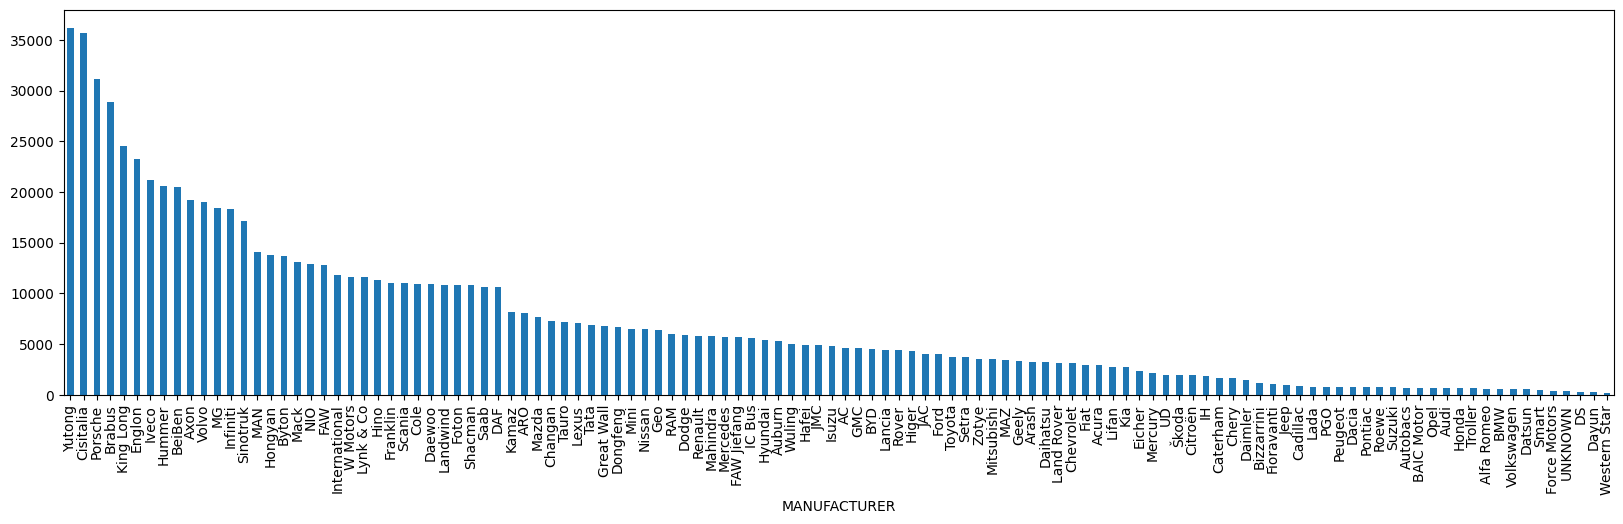

In [61]:
premium_by_manufacturer = (
    insurance_data.groupby("MANUFACTURER")["PREMIUM"]
    .median()
    .sort_values(ascending=False)
)

premium_by_manufacturer.plot(kind="bar", figsize=(20, 5))

The bar chart indicates anywhere from 3 to 5 possible groups. We can use k-means clustering to choose the number of groups for us. 

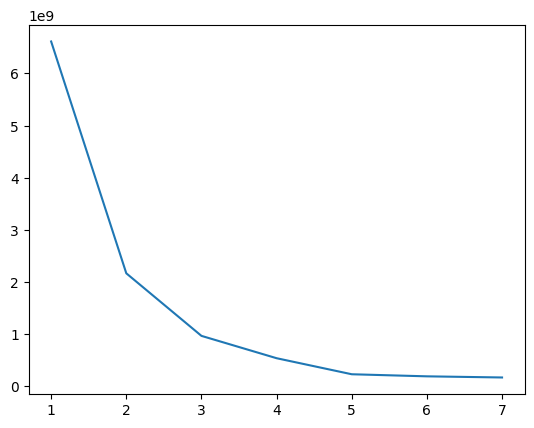

In [62]:
median_premium = insurance_data.groupby("MANUFACTURER")["PREMIUM"].median()

median_values = median_premium.values.reshape(-1, 1)

inertia = []
K = range(1, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=87).fit(median_values)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia)
plt.show()

The decrease of sum of squares becomes less gradual from 3 to 5. We'll use 4 clusters.

In [63]:
kmeans = KMeans(n_clusters=4, random_state=87).fit(median_values)

cluster_order = np.argsort(kmeans.cluster_centers_.ravel())

labels_map = {
    cluster_order[0]: "VERY LOW",
    cluster_order[1]: "LOW",
    cluster_order[2]: "MEDIUM",
    cluster_order[3]: "HIGH"
}

manufacturer_category = [labels_map[label] for label in kmeans.labels_]

insurance_data = insurance_data.merge(
    pd.DataFrame({
        "MANUFACTURER": median_premium.index,
        "MANUFACTURER_CATEGORY": manufacturer_category
    }),
    on="MANUFACTURER"
)

### Primary function of vehicle

In [64]:
insurance_data["USAGE"].value_counts()

USAGE
Own Goods                 203801
Private                   200830
Fare Paying Passengers    118010
General Cartage            98369
Own service                49193
Taxi                       46641
Others                      8336
Special Construction        3271
Ambulance                   3039
Learnes                     2773
Car Hires                   2567
Agricultural Own Farm       2334
Agricultural Any Farm       1659
Fire fighting                102
Name: count, dtype: int64

All functions seem valid.

In [65]:
insurance_data["USAGE"] = insurance_data["USAGE"].str.upper()

### Paid claim sum

In [66]:
insurance_data["CLAIM_PAID"] = insurance_data["CLAIM_PAID"].replace(np.nan, 0)

pd.set_option("display.float_format", "{:.2f}".format)

print(insurance_data["CLAIM_PAID"].describe())

count      740925.00
mean        18762.22
std        419260.84
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     152445764.90
Name: CLAIM_PAID, dtype: float64


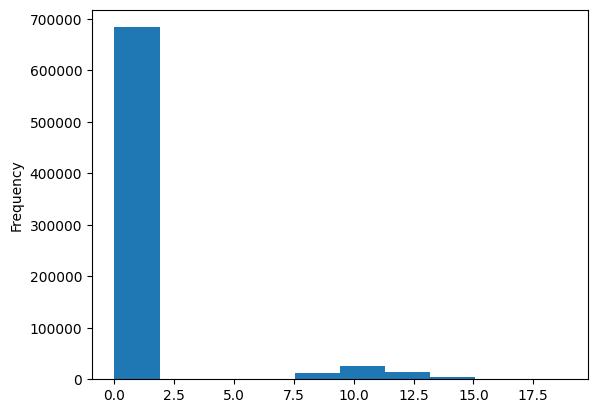

In [67]:
log_claim_paid = np.log(insurance_data["CLAIM_PAID"] + 1)

log_claim_paid.plot(kind="hist")

plt.show()

In [68]:
len(insurance_data[insurance_data["CLAIM_PAID"] == 0])

683401

The payout values seem realistic since they are in Ethiopian birr. The largest paid sum is around 1,100,000 USD.

There is one issue: even the log-transformed variable does not resemble any known distribution. Thus, we can create an additional variable that might perform better in the model.

In [69]:
insurance_data["WAS_CLAIM_PAID"] = np.where(insurance_data['CLAIM_PAID'] > 0, True, False)

insurance_data["WAS_CLAIM_PAID"].value_counts()

WAS_CLAIM_PAID
False    683401
True      57524
Name: count, dtype: int64

### Insurance premium

The premium amounts are provided in Ethiopian birr (1000 Birr = 7,3 USD).

In [70]:
insurance_data["PREMIUM"][insurance_data["PREMIUM"] <= 0].count()

np.int64(10)

There are 10 vehicles with a premium of 0 or less. This is not acceptable and we will remove them. I was informed by the publisher of the dataset that the company follows a principle of "No premium, no insurance", meaning they are no longer insured. This method of record keeping is ineffective.

In [71]:
insurance_data = insurance_data[insurance_data["PREMIUM"] > 0]

insurance_data["PREMIUM"].describe()

count   740896.00
mean      7469.85
std      10696.49
min          2.98
25%        756.20
50%       3271.52
75%       9726.72
max     330818.54
Name: PREMIUM, dtype: float64

From the variable description it becomes clear that it is nowhere close to normality.

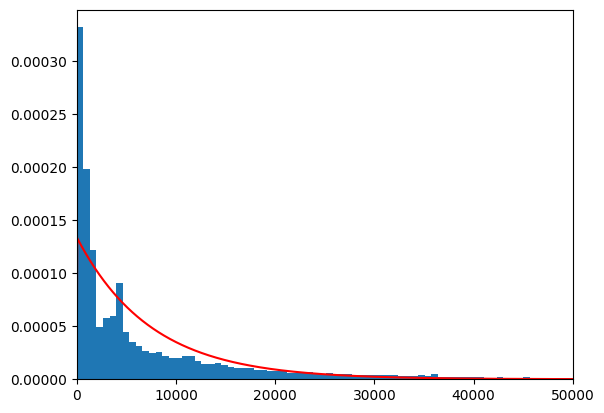

In [72]:
params = expon.fit(insurance_data["PREMIUM"])

x = np.linspace(0, 50000, 1000)
pdf = expon.pdf(x, *params)

plt.hist(insurance_data["PREMIUM"], bins=500, density=True)
plt.plot(x, pdf, 'r')
plt.xlim([0, 50000])
plt.show()

The distribution closely resembles an exponential one.

In [73]:
D, p_value = kstest(insurance_data["PREMIUM"], "expon", args=params)

print(f"P-value: {p_value:.4f}")

P-value: 0.0000


As the p-value is less than 0.05, we fail to reject the null hypothesis. This distribution might as well be exponential.

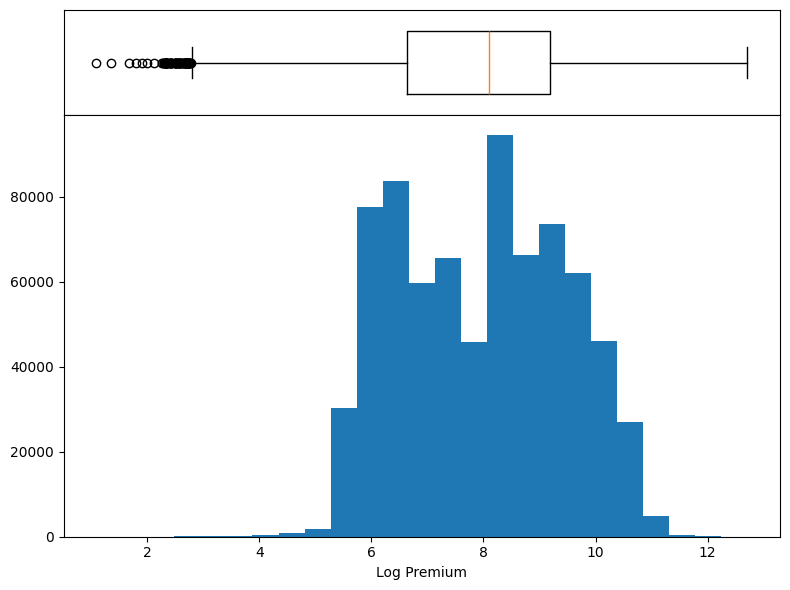

In [74]:
log_premiums = np.log(insurance_data["PREMIUM"])

fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 4]})

axes[0].boxplot(log_premiums, vert=False, widths=0.6)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].hist(log_premiums, bins=25)
axes[1].set_xlabel("Log Premium")

plt.tight_layout(h_pad=0)

plt.show()

### Additional variables for modelling

From the existing dataset variable we can create additional variables that, in theory, could provide better model outcomes.

#### Previous claim paid

If a vehicle is dangerous to operate this could be reflected in the total claim payout sum.

In [75]:
sorted_df = insurance_data.sort_values(["OBJECT_ID", "INSR_BEGIN"])

sorted_df["PREVIOUS_CLAIM_PAID"] = (
    sorted_df.groupby("OBJECT_ID")["CLAIM_PAID"]
    .cumsum()
    .shift(fill_value=0)
)

insurance_data["PREVIOUS_CLAIM_PAID"] = sorted_df["PREVIOUS_CLAIM_PAID"].reindex(insurance_data.index)


#### Previous policy holders

A greater number of previous reinsurances could also indicate greater risk.

In [76]:
sorted_df = insurance_data.sort_values(["OBJECT_ID", "INSR_BEGIN"])

sorted_df["PREVIOUS_POLICYHOLDERS"] = (
    sorted_df.groupby("OBJECT_ID").cumcount()
)

insurance_data["PREVIOUS_POLICYHOLDERS"] = sorted_df["PREVIOUS_POLICYHOLDERS"].reindex(insurance_data.index)

### Correlation between variables

Before moving to modelling, we first must check if we have correlation between variables and multicolinearity. If variables are colinear, they cannot exist in a linear model together.

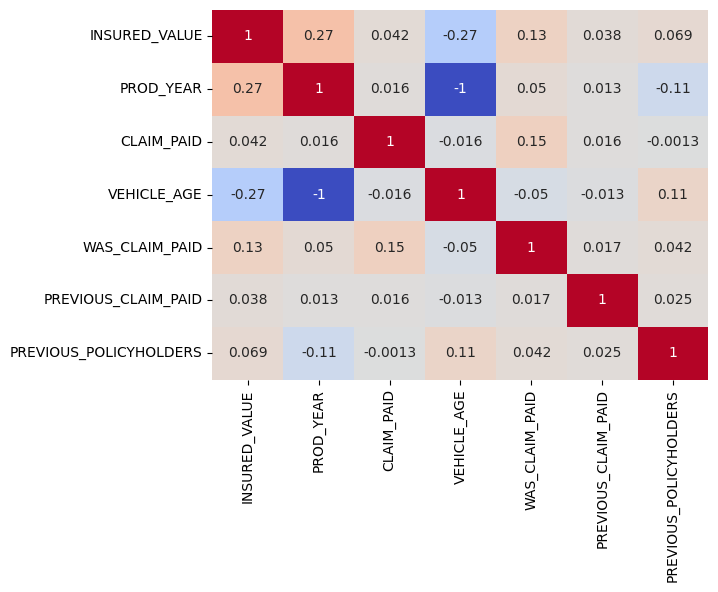

In [77]:
cont_cols = ["INSURED_VALUE", "PROD_YEAR", "CLAIM_PAID", 
        "VEHICLE_AGE", "WAS_CLAIM_PAID", 
        "PREVIOUS_CLAIM_PAID", "PREVIOUS_POLICYHOLDERS"]

corr = insurance_data[cont_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", cbar=False,
            xticklabels=cont_cols, yticklabels=cont_cols)

plt.show()

The vehicle age was calculated from the production year variable and therefore they cannot be used as regressors together.

In [78]:
num_cols = ["INSURED_VALUE", "CLAIM_PAID", "VEHICLE_AGE", 
            "PREVIOUS_CLAIM_PAID", "PREVIOUS_POLICYHOLDERS"]

vif_data = pd.DataFrame()
vif_data["Feature"] = insurance_data[num_cols].columns
vif_data["VIF"] = [variance_inflation_factor(insurance_data[num_cols].values, i)
                   for i in range(insurance_data[num_cols].shape[1])]

print(vif_data)

                  Feature  VIF
0           INSURED_VALUE 1.17
1              CLAIM_PAID 1.00
2             VEHICLE_AGE 1.55
3     PREVIOUS_CLAIM_PAID 1.01
4  PREVIOUS_POLICYHOLDERS 1.68


## Modelling

### Linear regression

In [79]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 740896 entries, 0 to 740924
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   SEX                     740896 non-null  object        
 1   INSR_BEGIN              740896 non-null  datetime64[ns]
 2   INSR_END                740896 non-null  datetime64[ns]
 3   INSR_TYPE               740896 non-null  object        
 4   INSURED_VALUE           740896 non-null  float64       
 5   PREMIUM                 740896 non-null  float64       
 6   OBJECT_ID               740896 non-null  int64         
 7   PROD_YEAR               740896 non-null  float64       
 8   TYPE_VEHICLE            740896 non-null  object        
 9   MAKE                    740896 non-null  object        
 10  USAGE                   740896 non-null  object        
 11  CLAIM_PAID              740896 non-null  float64       
 12  LOG_PREMIUM             740896 non-

We are left with 16 variables that could be used for modelling: `SEX`, `INSR_TYPE`, `INSURED_VALUE`, `PROD_YEAR`, `TYPE_VEHICLE`, `USAGE`, `CLAIM_PAID`, `INSR_COVER`, `INSR_START_DAY/MONTH/YEAR`, `INSR_COVER`, `VEHICLE_AGE`, `MANUFACTURER`, `MANUFACTURER_CATEGORY`, `WAS_CLAIM_PAID`, `PREVIOUS_CLAIM_PAID` and `PREVIOUS_POLICYHOLDERS`.

We will select variables by using adjusted R<sup>2</sup> as a guiding measure.

#### Model #1

In [80]:
model1 = LinearRegression()

X = insurance_data[["SEX","INSR_TYPE", "INSURED_VALUE_GROUP",
                    "PROD_YEAR", "TYPE_VEHICLE", "USAGE",
                    "INSR_COVER", "CLAIM_PAID", "MANUFACTURER",
                    "VEHICLE_AGE", "WAS_CLAIM_PAID", "PREVIOUS_CLAIM_PAID",
                    "PREVIOUS_POLICYHOLDERS"]].copy()

X = pd.get_dummies(X, columns=["SEX", "INSR_TYPE", "PROD_YEAR",
                               "TYPE_VEHICLE", "USAGE", "INSR_COVER",
                               "MANUFACTURER", "WAS_CLAIM_PAID", "INSURED_VALUE_GROUP"], drop_first=True)

Y = insurance_data["LOG_PREMIUM"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

model1.fit(X_train, Y_train)

Y_pred = model1.predict(X_test)

r_sq = model1.score(X_test, Y_test)

r_sq_adj = 1 - (1 - r_sq) * (len(Y) - 1) / (len(Y) - X.shape[1] - 1)

mae = mean_absolute_error(Y_test, Y_pred)

print(f"Adjusted R^2: {r_sq_adj:.4f}, MAE: {mae:.2f}")

Adjusted R^2: 0.8408, MAE: 0.39


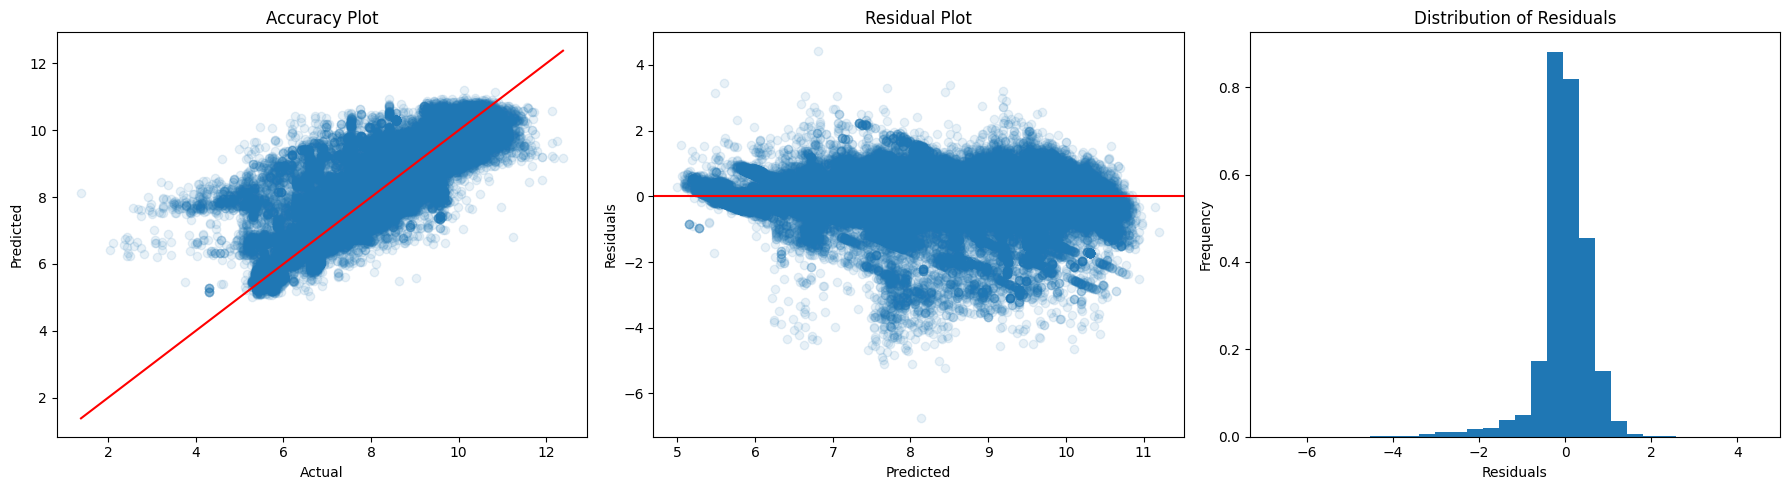

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_test, Y_pred, alpha=0.1)
axes[0].plot([Y_test.min(), Y_test.max()],
             [Y_test.min(), Y_test.max()],
             'r')
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

axes[1].scatter(Y_pred, Y_test - Y_pred, alpha=0.1)
axes[1].axhline(y=0, color='r')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")

axes[2].hist(Y_test - Y_pred, bins=30, density=True)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

In [82]:
correlation = np.corrcoef(Y_test, Y_pred)[0, 1]
print(f"Correlation: {correlation:.2f}")

Correlation: 0.92


In [83]:
X_with_const = sm.add_constant(X)

X_with_const = X_with_const.astype(float)
Y = Y.astype(float)

model = sm.OLS(Y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LOG_PREMIUM   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 1.849e+04
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:46:57   Log-Likelihood:            -6.6320e+05
No. Observations:              740896   AIC:                         1.327e+06
Df Residuals:                  740679   BIC:                         1.329e+06
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

With almost all variables included in the model, we are getting an R<sup>2</sup> of 0.844. This is far from ideal, especially considering that we have not yet selected the best regressors.

Now that we have a preminary model, we can look at the t-statistics individually. Practically all dummy variables for production year before the 2000s are not meaningful in the model. We can create a new grouped variable that indicates production before and after the 2000s. The same is true for the manufacturer variable - we will replace it with the manufacturer category variable.

We also cannot leave the insured value variable in the model as it was used to construct the insurance coverage variable.

In [84]:
insurance_data["MADE_AFTER_1999"] = np.where(insurance_data["PROD_YEAR"] > 1999, 1, 0)

#### Model #2

In [85]:
model2 = LinearRegression()

X = insurance_data[["SEX","INSR_TYPE", "MADE_AFTER_1999",
                    "TYPE_VEHICLE", "USAGE", "INSR_COVER",
                    "CLAIM_PAID", "MANUFACTURER_CATEGORY",
                    "WAS_CLAIM_PAID", "PREVIOUS_CLAIM_PAID",
                    "PREVIOUS_POLICYHOLDERS", "INSURED_VALUE_GROUP"]].copy()

X = pd.get_dummies(X, columns=["SEX", "INSR_TYPE", "TYPE_VEHICLE",
                               "USAGE", "INSR_COVER", "MANUFACTURER_CATEGORY",
                               "INSURED_VALUE_GROUP", "WAS_CLAIM_PAID"], drop_first=True)

Y = insurance_data["LOG_PREMIUM"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

model2.fit(X_train, Y_train)

Y_pred = model2.predict(X_test)

r_sq = model2.score(X_test, Y_test)

r_sq_adj = 1 - (1 - r_sq) * (len(Y) - 1) / (len(Y) - X.shape[1] - 1)

mae = mean_absolute_error(Y_test, Y_pred)

print(f"Adjusted R^2: {r_sq_adj:.4f}, MAE: {mae:.2f}")

Adjusted R^2: 0.8327, MAE: 0.41


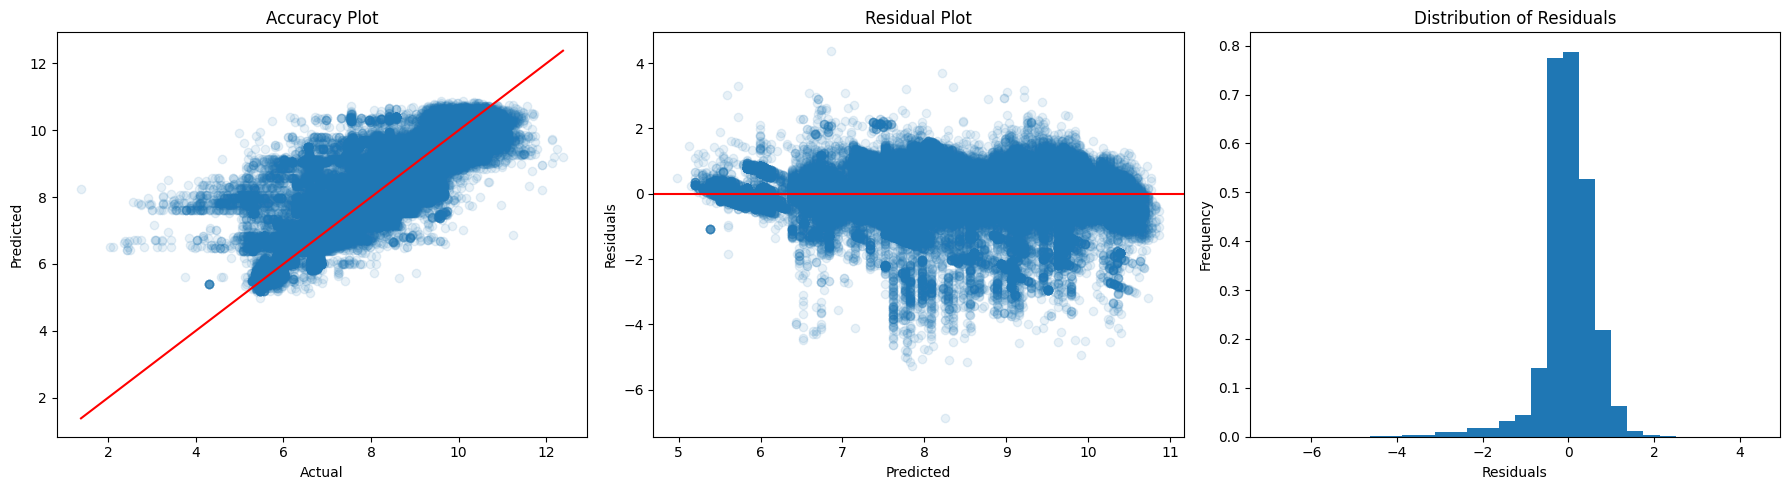

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_test, Y_pred, alpha=0.1)
axes[0].plot([Y_test.min(), Y_test.max()],
             [Y_test.min(), Y_test.max()],
             "r")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

axes[1].scatter(Y_pred, Y_test - Y_pred, alpha=0.1)
axes[1].axhline(y=0, color="r")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")

axes[2].hist(Y_test - Y_pred, bins=30, density=True)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

In [87]:
X_with_const = sm.add_constant(X)

X_with_const = X_with_const.astype(float)
Y = Y.astype(float)

model = sm.OLS(Y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LOG_PREMIUM   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 1.015e+05
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:47:01   Log-Likelihood:            -6.8237e+05
No. Observations:              740896   AIC:                         1.365e+06
Df Residuals:                  740858   BIC:                         1.365e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

After dropping the production year & original manufacturer variable through backward selection, we are left with 12 variables and an R<sup>2</sup> of 0.8327. That greatly simplified our model while providing similar results, but it is clear that linear regression is not the ideal model candidate for premium predictions. The distribution of errors is nowhere near normal and quite a few of linear regression assumptions are not met: linearity, homoscedasticity. The relationship between the regressors and premium values is not linear. Different models should be tested for their predictive ability.

### XGBoost

#### Model #3

Another model that we could test is XGBoost. It can handle non-linear relationships between variables and can potencially achieve better accuracy. We'll begin by adding all possible variables into the model.

R² Adjusted: 0.9170
MAE: 0.25


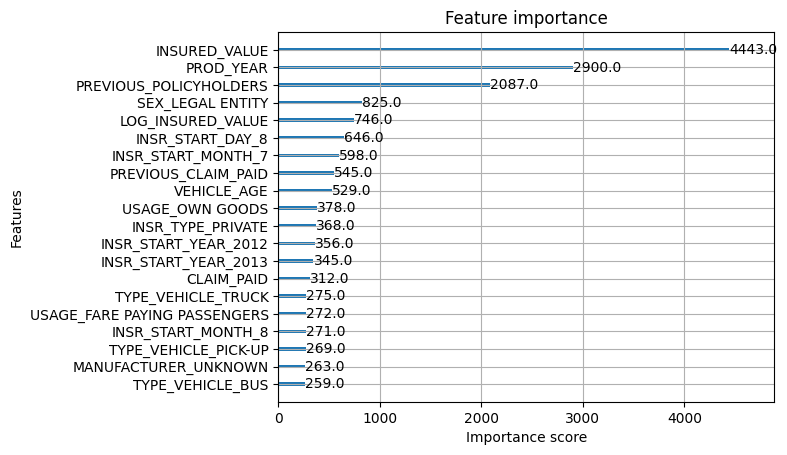

In [88]:
X = insurance_data[[
    "SEX", "INSR_TYPE", "INSURED_VALUE", "CLAIM_PAID",
    "INSR_COVER", "MANUFACTURER", "TYPE_VEHICLE", "USAGE",
    "PROD_YEAR", "INSR_START_MONTH", "INSR_START_YEAR",
    "INSR_START_DAY", "VEHICLE_AGE", "WAS_CLAIM_PAID",
    "PREVIOUS_CLAIM_PAID", "PREVIOUS_POLICYHOLDERS",
    "INSURED_VALUE_GROUP", "MANUFACTURER_CATEGORY"
]].copy()

X["LOG_INSURED_VALUE"] = np.log1p(X["INSURED_VALUE"] + 1)
X["LOG_CLAIM_PAID"] = np.log1p(X["CLAIM_PAID"] + 1)

X = pd.get_dummies(
    X,
    columns=["SEX", "INSR_TYPE", "INSR_COVER", "MANUFACTURER", "TYPE_VEHICLE", "USAGE",
             "INSR_START_MONTH", "INSR_START_YEAR", "INSR_START_DAY",
             "WAS_CLAIM_PAID", "INSURED_VALUE_GROUP", "MANUFACTURER_CATEGORY"],
    drop_first=True
)

Y = insurance_data["LOG_PREMIUM"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=87
)

model3 = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=87,
    n_jobs=-1
)

model3.fit(X_train, Y_train)

Y_pred = model3.predict(X_test)

r_sq = r2_score(Y_test, Y_pred)
r_sq_adj = 1 - (1 - r_sq) * (len(Y) - 1) / (len(Y) - X.shape[1] - 1)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"R² Adjusted: {r_sq_adj:.4f}")
print(f"MAE: {mae:.2f}")

xgb.plot_importance(model3, max_num_features=20, importance_type='weight')
plt.show()

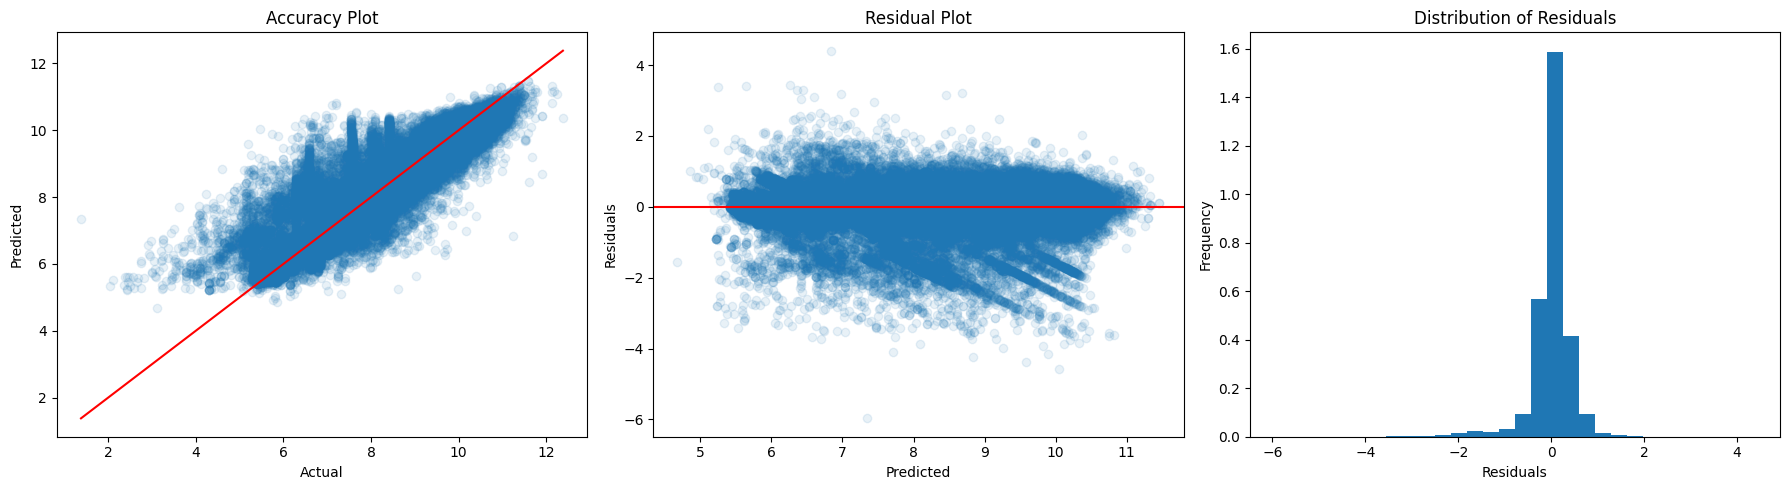

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_test, Y_pred, alpha=0.1)
axes[0].plot([Y_test.min(), Y_test.max()],
             [Y_test.min(), Y_test.max()],
             "r")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

axes[1].scatter(Y_pred, Y_test - Y_pred, alpha=0.1)
axes[1].axhline(y=0, color="r")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")

axes[2].hist(Y_test - Y_pred, bins=30, density=True)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

By keeping all variables and only changing the model we are getting an adjusted R<sup>2</sup> of 0.9170. That is a great improvement over 0.8327. Our accuracy plot data points are more concentrated around the accuracy line. The residual plot still shows non-random concentration around the line and the spike around 0 in the residual distribution is quite normal as it shows that the model is accurate for most of the data.

#### Model #4

Still, there is room for improvement. We can remove that less meaningful variables from the feature importance chart and log-transform the premium values.

R²: 0.9006
MAE: 0.28


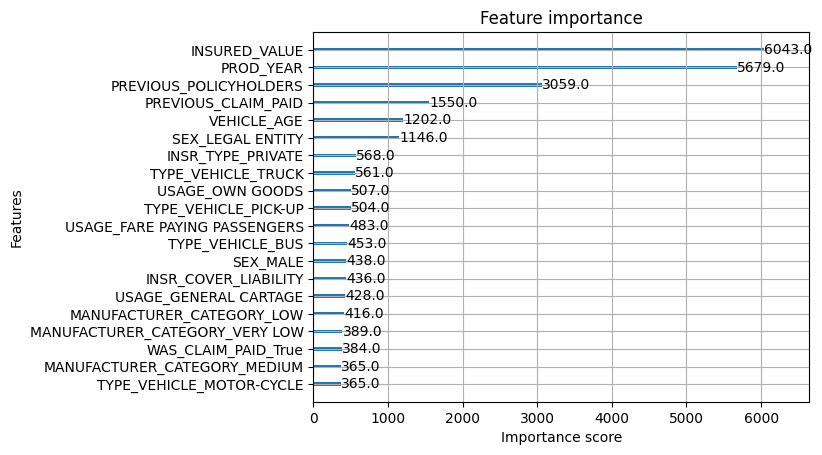

In [90]:
X = insurance_data[[
    "SEX", "INSR_TYPE", "INSURED_VALUE",
    "INSR_COVER", "TYPE_VEHICLE", "USAGE",
    "PROD_YEAR", "VEHICLE_AGE", "WAS_CLAIM_PAID",
    "PREVIOUS_CLAIM_PAID", "PREVIOUS_POLICYHOLDERS",
    "INSURED_VALUE_GROUP", "MANUFACTURER_CATEGORY"
]].copy()

X = pd.get_dummies(
    X,
    columns=["SEX", "INSR_TYPE", "INSR_COVER", "TYPE_VEHICLE",
             "USAGE", "WAS_CLAIM_PAID", "INSURED_VALUE_GROUP",
             "MANUFACTURER_CATEGORY"],
    drop_first=True
)

Y = insurance_data["LOG_PREMIUM"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=87
)

model3 = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=87,
    n_jobs=-1
)

model3.fit(X_train, Y_train)

Y_pred = model3.predict(X_test)

r_sq = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"R²: {r_sq:.4f}")
print(f"MAE: {mae:.2f}")

xgb.plot_importance(model3, max_num_features=20, importance_type='weight')
plt.show()

After feature selection, we are left with 13 meaningful variables. Some variables that were quite good predictors, such as insurance start day, were not keep as they would not be known to the insurer prior. Other variables, such as previous policy holders and previous claim paid, that were feature-enginnered proved extemely valuable. Also, the log-transformation of premiums also improved model performance.

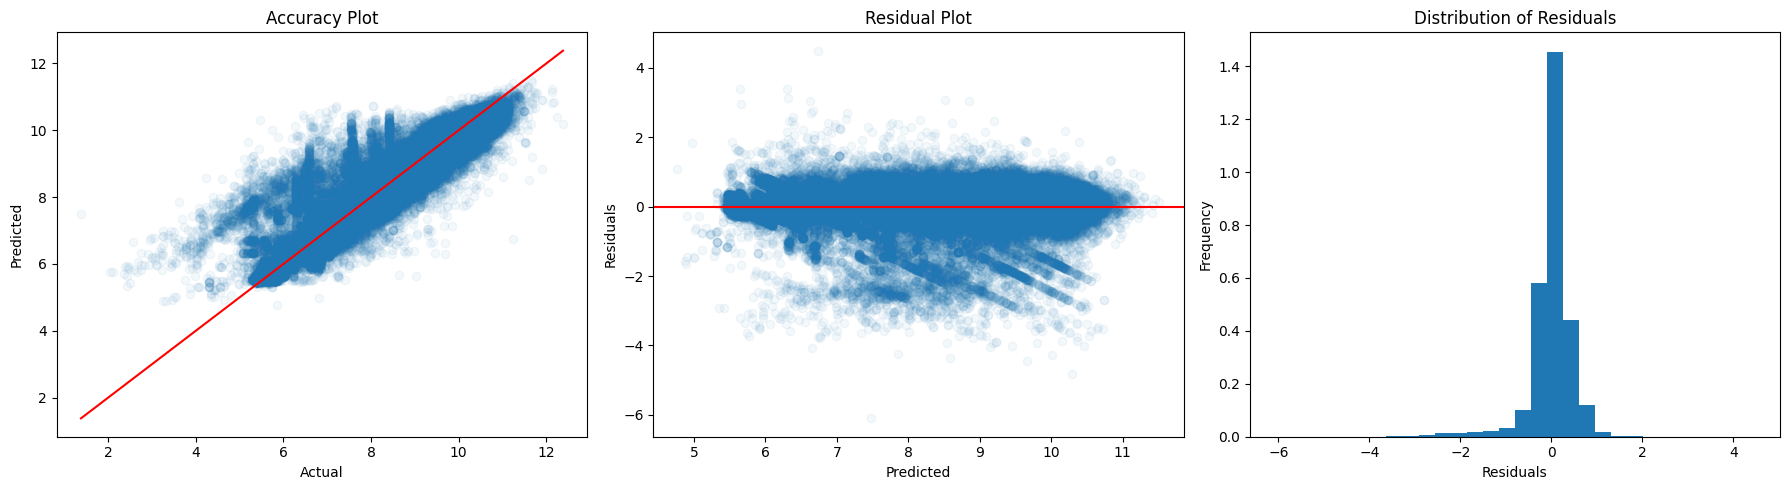

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_test, Y_pred, alpha=0.05)
axes[0].plot([Y_test.min(), Y_test.max()],
             [Y_test.min(), Y_test.max()],
             "r")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

axes[1].scatter(Y_pred, Y_test - Y_pred, alpha=0.05)
axes[1].axhline(y=0, color="r")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")

axes[2].hist(Y_test - Y_pred, bins=30, density=True)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

As we can see from the accuracy plot, the data points have enveloped the accuracy line, with the same being in the residual plot. The distribution of residuals have also taken a more normal-looking distribution with the spike at 0 being less pronounced. The lines that appear in the accuracy & residuals plots are most likely caused by rounded insurance premium values in the original dataset.

#### Bayesian optimization

One other way that could improve the machine learning model is by using Bayesian optimization. Instead of going through all available parameter combinations, we can use stochastic methods to look for the minimum in our loss function. For that, we'll use the hyperopt library functionalities.

In [92]:
feature_names = X_train.columns.tolist()

X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=Y_test, feature_names=feature_names)

In [93]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'tree_method': 'gpu_hist',
        'device': 'cuda',
        'objective': 'reg:squarederror',
        'verbosity': 0,
    }

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    preds = bst.predict(dtest)
    mae = mean_absolute_error(Y_test, preds)

    trial.set_user_attr('model', bst)

    return mae

In [95]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=-1)

best_params = study.best_params

final_model = study.best_trial.user_attrs['model']

Y_pred = final_model.predict(dtest)
r_sq = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print("Best hyperparameters:", best_params)
print(f"Final R²: {r_sq:.4f}")
print(f"Final MAE: {mae:.2f}")

Best hyperparameters: {'n_estimators': 825, 'max_depth': 11, 'learning_rate': 0.07378986001996814, 'subsample': 0.8615087965672834, 'colsample_bytree': 0.8704188481048465, 'gamma': 0.006517492000758518, 'min_child_weight': 1}
Final R²: 0.9159
Final MAE: 0.25


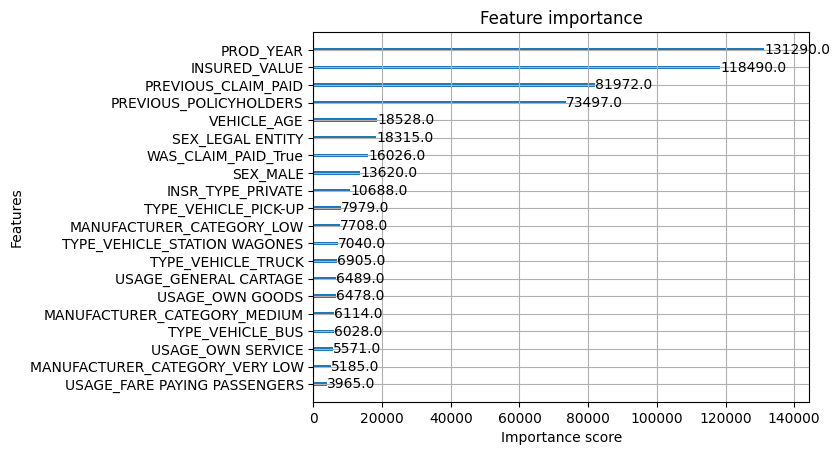

In [96]:
xgb.plot_importance(final_model, max_num_features=20, importance_type='weight')
plt.show()

After testing 200 combinations of variables, a Mean Square Error of 0.25 was achieved. With the optimal hyperparamets, the model achieved an adjusted R<sup>2</sup> of 0.9159, an improvement of 0.0153 over the previous model.

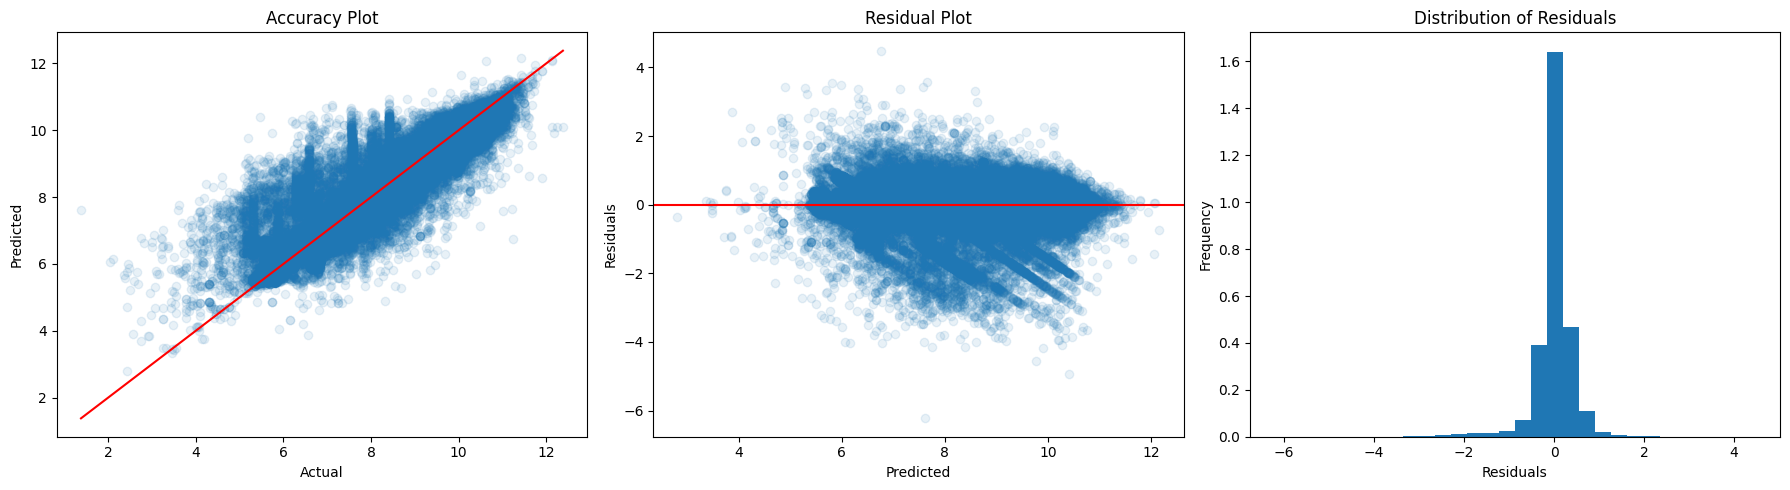

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_test, Y_pred, alpha=0.1)
axes[0].plot([Y_test.min(), Y_test.max()],
             [Y_test.min(), Y_test.max()],
             "r")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

axes[1].scatter(Y_pred, Y_test - Y_pred, alpha=0.1)
axes[1].axhline(y=0, color="r")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")

axes[2].hist(Y_test - Y_pred, bins=30, density=True)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

## Model deployment

With model training completed, we can now deploy it using Docker and an API. Steps on how to run the Docker container are provided in the readme file.